# Generate TFRecords from datasets and supervised poses

## Setup

In [34]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from utils.tf_records_generator import *
from utils.plotter import *

import glob

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define files paths here

<font color='red'> Do not forget '/' at end of every path. </font>

In [2]:
# DATASET_PATH = "/home/kingkolibri/10_catkin_ws/20190825_OutsideAudimax/" # Do not forget '/' at the end
# POSES_PATH = DATASET_PATH + "results/output/"
DATASET_PATH = "/home/kingkolibri/10_catkin_ws/20190825_OutsideAudimax/"
POSES_PATH = DATASET_PATH + "results/poses/"

In [3]:
P2G_TEST_SET_PATH = "/home/kingkolibri/10_catkin_ws/test_records/"
P2G_TRAIN_SET_PATH = "/home/kingkolibri/10_catkin_ws/train_records/"

WLB_TEST_SET_PATH = "/home/kingkolibri/10_catkin_ws/test_hdf5/"
WLB_TRAIN_SET_PATH = "/home/kingkolibri/10_catkin_ws/train_hdf5/"

TOPOSENS_PATH = "/home/kingkolibri/10_catkin_ws/toposens_files/"

In [4]:
folder_name = DATASET_PATH.split("/")[-2]
folder_name

'20190825_OutsideAudimax'

In [5]:
# Fancy progress bar
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [6]:
files = glob.glob(DATASET_PATH + "*.pkl")
rosbag_files = [file for file in files if file.split('/')[-1].startswith('merged')]
rosbag_files.sort()
rosbag_files

['/home/kingkolibri/10_catkin_ws/20190825_OutsideAudimax/merged_20190825_OutsideAudimax.pkl']

## Supervise dataframe

In [7]:
# Load list of rostimes per video frame
import pickle
with open(DATASET_PATH + 'rostimes_synchronized.pkl', 'rb') as f:
    rostimes = pickle.load(f)

In [8]:
keypoint_columns = {
    'Nose' : 0,
    'Neck' : 1,
    'RShoulder' : 2,
    'RElbow' : 3,
    'RWrist' : 4,
    'LShoulder' : 5,
    'LElbow' : 6,
    'LWrist' : 7, # LWrist
    'MidHip' : 8,
    'RHip' : 9, # RHip
    'RKnee' : 10, # RKnee
    'RAnkle' : 11,# RAnkle
    'LHip' : 12,# LHip
    'LKnee' : 13,# LKnee
    'LAnkle' : 14,# LAnkle
    'REye' : 15,# REye
    'LEye' : 16,# LEye
    'REar' : 17,# REar
    'LEar' : 18,# LEar
    'LBigToe': 19,
    'LSmallToe': 20,
    'LHeel' : 21,
    'RBigToe': 22,
    'RSmallToe': 23,
    'RHeel' : 24,
    'Background' : 25
}

keypoint_keys = list(keypoint_columns.keys())


In [9]:
rosbag_files

['/home/kingkolibri/10_catkin_ws/20190825_OutsideAudimax/merged_20190825_OutsideAudimax.pkl']

In [ ]:
import json

data = pd.DataFrame()

for file in rosbag_files:
  
    dataset = pd.read_pickle(file)
    num_rows = dataset.shape[0]
    
    for index, row in dataset.iterrows():

        update_progress(index/num_rows)

        row_data = row.to_dict();

        rostime = row_data['rostime']

        with open(POSES_PATH + "/raw_video_{}_keypoints.json".format(str(rostimes.index(rostime)).zfill(12)), 'r') as file:
            parsed = json.load(file)

        sample_dict = {}

        num_persons = np.minimum(2, len(parsed['part_candidates']))

        for person in range(0, num_persons):
            for key in parsed['part_candidates'][person].keys():
                if parsed['part_candidates'][person][key]:
                    sample_dict['keypoint_{0}_{1}_x'.format(person, keypoint_keys[int(key)])] = parsed['part_candidates'][person][key][0]
                    sample_dict['keypoint_{0}_{1}_y'.format(person, keypoint_keys[int(key)])] = parsed['part_candidates'][person][key][1]   
                    sample_dict['keypoint_{0}_{1}_score'.format(person, keypoint_keys[int(key)])] = parsed['part_candidates'][person][key][2]
                else:
                    sample_dict['keypoint_{0}_{1}_x'.format(person, keypoint_keys[int(key)])] = None
                    sample_dict['keypoint_{0}_{1}_y'.format(person, keypoint_keys[int(key)])] = None
                    sample_dict['keypoint_{0}_{1}_score'.format(person, keypoint_keys[int(key)])] = None 

        row_data.update(sample_dict)

        data = data.append(row_data, ignore_index=True)
        
update_progress(1)

### Extract data for toposens

In [11]:
toposens_columns = [column for column in data.columns 
                    if not (column.startswith("p2g") or 
                            column.startswith("timestamp") or 
                            column.startswith("raw"))
                   ]

data[toposens_columns].to_pickle(TOPOSENS_PATH + "ts3-{0}.pickle.zip".format(folder_name), compression="zip")

## Keypoints heatmaps

In [12]:
# Set hyper parameters
num_pixel_width = 64
num_pixel_height = 64
sigma = 5

In [13]:
# Uncomment keypoints to consider
landmark_columns = [
    ['keypoint_0_LAnkle_x','keypoint_0_LAnkle_y'], 
    #['keypoint_0_LBigToe_x', 'keypoint_0_LBigToe_y'], 
    #['keypoint_0_LEar_x', 'keypoint_0_LEar_y'], 
    ['keypoint_0_LElbow_x', 'keypoint_0_LElbow_y'], 
    #['keypoint_0_LEye_x', 'keypoint_0_LEye_y'], 
    #['keypoint_0_LHeel_x', 'keypoint_0_LHeel_y'], 
    ['keypoint_0_LHip_x', 'keypoint_0_LHip_y'], 
    ['keypoint_0_LKnee_x', 'keypoint_0_LKnee_y'],
    ['keypoint_0_LShoulder_x','keypoint_0_LShoulder_y'], 
    #['keypoint_0_LSmallToe_x', 'keypoint_0_LSmallToe_y'],
    ['keypoint_0_LWrist_x', 'keypoint_0_LWrist_y'],
    #['keypoint_0_MidHip_x', 'keypoint_0_MidHip_y'],
    #['keypoint_0_Neck_x', 'keypoint_0_Neck_y'],
    ['keypoint_0_Nose_x', 'keypoint_0_Nose_y'],
    ['keypoint_0_RAnkle_x', 'keypoint_0_RAnkle_y'],
    #['keypoint_0_RBigToe_x','keypoint_0_RBigToe_y'], 
    #['keypoint_0_REar_x','keypoint_0_REar_y'], 
    ['keypoint_0_RElbow_x','keypoint_0_RElbow_y'], 
    #['keypoint_0_REye_x','keypoint_0_REye_y'], 
    #['keypoint_0_RHeel_x','keypoint_0_RHeel_y'], 
    ['keypoint_0_RHip_x','keypoint_0_RHip_y'], 
    ['keypoint_0_RKnee_x','keypoint_0_RKnee_y'], 
    ['keypoint_0_RShoulder_x', 'keypoint_0_RShoulder_y'], 
    #['keypoint_0_RSmallToe_x', 'keypoint_0_RSmallToe_y'], 
    ['keypoint_0_RWrist_x', 'keypoint_0_RWrist_y'],
#    ['keypoint_1_LAnkle_x','keypoint_1_LAnkle_y'], 
#    #['keypoint_1_LBigToe_x', 'keypoint_1_LBigToe_y'], 
#    #['keypoint_1_LEar_x', 'keypoint_1_LEar_y'], 
#    ['keypoint_1_LElbow_x', 'keypoint_1_LElbow_y'], 
#    #['keypoint_1_LEye_x', 'keypoint_1_LEye_y'], 
#    #['keypoint_1_LHeel_x', 'keypoint_1_LHeel_y'], 
#    ['keypoint_1_LHip_x', 'keypoint_1_LHip_y'], 
#    ['keypoint_1_LKnee_x', 'keypoint_1_LKnee_y'],
#    ['keypoint_1_LShoulder_x','keypoint_1_LShoulder_y'], 
#    #['keypoint_1_LSmallToe_x', 'keypoint_1_LSmallToe_y'],
#    ['keypoint_1_LWrist_x', 'keypoint_1_LWrist_y'],
#    #['keypoint_1_MidHip_x', 'keypoint_1_MidHip_y'],
#    #['keypoint_1_Neck_x', 'keypoint_1_Neck_y'],
#    ['keypoint_1_Nose_x', 'keypoint_1_Nose_y'],
#    ['keypoint_1_RAnkle_x', 'keypoint_1_RAnkle_y'],
#    #['keypoint_1_RBigToe_x','keypoint_1_RBigToe_y'], 
#    #['keypoint_1_REar_x','keypoint_1_REar_y'], 
#    ['keypoint_1_RElbow_x','keypoint_1_RElbow_y'], 
#    #['keypoint_1_REye_x','keypoint_1_REye_y'], 
#    #['keypoint_1_RHeel_x','keypoint_1_RHeel_y'], 
#    ['keypoint_1_RHip_x','keypoint_1_RHip_y'], 
#    ['keypoint_1_RKnee_x','keypoint_1_RKnee_y'], 
#    ['keypoint_1_RShoulder_x', 'keypoint_1_RShoulder_y'], 
#    #['keypoint_1_RSmallToe_x', 'keypoint_1_RSmallToe_y'], 
#    ['keypoint_1_RWrist_x', 'keypoint_1_RWrist_y'] 
]


In [14]:
def gaussian_k(x0, y0, sigma, height, width):
    """ Make a square gaussian kernel centered at (x0, y0) with sigma as SD.
    """
    y = np.arange(0, width, 1, float)
    x = np.arange(0, height, 1, float)[:, np.newaxis]
    return np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))


In [15]:
def generate_heatmap(height, width, landmarks, sigma=3):
    """ Generate a full heat map for every landmark in an array
    """
    num_landmarks = landmarks.shape[0]
    hm = np.zeros((height, width, num_landmarks), dtype=np.float32)
    for i in range(num_landmarks):
        if not np.array_equal(landmarks[i], [-1, -1]):

            hm[:, :, i] = gaussian_k(landmarks[i][1] * height,
                                     landmarks[i][0] * width,
                                     sigma,
                                     height, width)
        else:
            hm[:, :, i] = np.zeros((height, width))

    return hm

## Position2Go recordings

In [16]:
# Set hyperparameters
num_frames = 2 # = 2seconds windows
num_chirps = 16

### Compose radar matrix windows

In [17]:
X =  []

shape = np.array(data.p2g_0_0real.tolist()).shape

for board in range(0,4):
    for antenna in range(0,2):
        key = "p2g_{0}_{1}".format(board, antenna)
        
        samples = []
        
        if data[key + "real"][0]:
            for row in data[key + "real"]:
                if not row:
                    samples.append(-1*np.ones((1024)))
                else:
                    samples.append(row)
                
            samples = np.array(samples)
            print(samples.shape)
            # samples = np.array(data[key + "real"].tolist())# + np.asarray(data[key + "imag"].tolist())*1j
        else:
            samples = -1 * np.ones(shape)

        X.append(samples.T)



(4969, 1024)
(4969, 1024)
(4969, 1024)
(4969, 1024)
(4969, 1024)
(4969, 1024)


In [18]:
X = np.array(X).T

In [19]:
X_wlb = []
for row in data['raw_image/img']:
    if row == row: # check if is not NaN
        X_wlb.append(row)
    
X_wlb = np.array(X_wlb)
print(X_wlb.shape)

(4967, 116, 25)


### Compute range-doppler maps

In [20]:
def compute_rd_maps(x, window_func='hamming'):
    
    rd_maps = []

    n = 128 #int(2**np.ceil(np.log2(x.shape[1])))
    m = 128 #int(2**np.ceil(np.log2(x.shape[0])))

    if window_func == 'hamming':
        window = np.hanning(x.shape[1])
    else:
        window = np.ones(x.shape[1])

    for radar_matrix in x.T:

        range_matrix = []
        
        # apply fast time fft
        for chirp in radar_matrix.T:
            range_matrix.append(np.fft.fft(chirp*window - np.mean(chirp), n=n))

        range_matrix = np.array(range_matrix)

        # apply slow time fft
        rd_map = []
        for range_bin in range_matrix.T:
            rd_map.append(np.fft.fft(range_bin, m))

        rd_maps.append(rd_map)

    return np.array(rd_maps).transpose()

## Generate TFRecords

In [21]:
number_of_elements = int(data.shape[0]/2-num_frames)
number_of_elements

2482

In [22]:
# Prepare writers for TFRecords
p2g_writer = tf.python_io.TFRecordWriter(P2G_TRAIN_SET_PATH + "/p2g_{0}.tfrecord".format(folder_name))
ts3_writer = tf.python_io.TFRecordWriter(P2G_TRAIN_SET_PATH + "/ts3_{0}.tfrecord".format(folder_name))

In [36]:
test_set_break = int(number_of_elements*0.85)+int(number_of_elements*0.85)%2

iterator = iter(range(0, number_of_elements, 2))

In [37]:
plotter = Plotter()

In [38]:
next(iterator)

0

In [84]:
heatmaps_arr = []
X_rdm_arr = []

Progress: [###-----------------] 16.4%


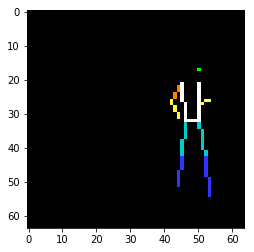

In [254]:
i = next(iterator)

update_progress(i / number_of_elements)

row = data.iloc[i+num_frames]

# Generate heatmaps
landmarks = []
for cols in landmark_columns:
    try:
        landmarks.append([row[cols[0]]/640, row[cols[1]]/480 ])
    except TypeError:
        landmarks.append([-1, -1])

landmarks = np.array(landmarks)

heatmaps = generate_heatmap(num_pixel_height, 
                            num_pixel_width, 
                            landmarks, 
                            sigma=sigma
                           )

# TS3 data   
ts3_writer.write(generate_ts3_feature(ts3_points=[row['ts3_0'], row['ts3_1']], 
                                      heatmaps=heatmaps, 
                                      filename=row['filename']
                                      ).SerializeToString())

# P2G data
# Compose radar matrix
X_raw = np.reshape(X[i:i+num_frames:2], (64, 64, num_frames), 'C')

# Compute rd-map
X_rdm = compute_rd_maps(X_raw)

p2g_writer.write(generate_p2g_feature(X_rdm=X_rdm, 
                                      heatmaps=heatmaps, 
                                      filename=row['filename']
                                      ).SerializeToString())

# Last 15% of each dataset is going to build our test set     
if i == test_set_break:
    print("Starting test set")

    p2g_writer.close()
    ts3_writer.close()

    p2g_writer = tf.python_io.TFRecordWriter(P2G_TEST_SET_PATH + "/p2g_{0}.tfrecord".format(folder_name))
    ts3_writer = tf.python_io.TFRecordWriter(P2G_TEST_SET_PATH + "/ts3_{0}.tfrecord".format(folder_name))
        
plt.imshow(plotter.plot_stick_man(heatmaps))

In [255]:
heatmaps_arr.append(heatmaps)
X_rdm_arr.append(X_rdm)

In [256]:
len(c)

12

In [257]:
p2g_writer.close()
p2g_writer = tf.python_io.TFRecordWriter(P2G_TRAIN_SET_PATH + "/p2g_{0}.tfrecord".format(folder_name))

for i in range(len(heatmaps_arr)):
    p2g_writer.write(generate_p2g_feature(X_rdm=X_rdm_arr[i], 
                                      heatmaps=heatmaps_arr[i], 
                                      filename='0'
                                      ).SerializeToString())
p2g_writer.close()

In [ ]:
p2g_writer.close()
ts3_writer.close()

update_progress(1) # Finished

In [ ]:
X_wlb.min()

In [ ]:
X_wlb.dtype

In [ ]:
hdf5_file.close()

In [574]:
import h5py

def write_to_wlb_hdf(path, filename, input_data, label_data):
    input_shape = (8, 116, 25)
    label_shape = (13, 116, 25)

    try:
        os.remove(path + filename)
    except:
        pass

    # open a hdf5 file and create arrays
    hdf5_file = h5py.File(path + filename, mode='w')

    for i in range(len(input_data)):
        group = hdf5_file.create_group(str(i))
        # changed np.uint to float in raw image
        group.create_dataset("raw_image", input_shape, np.float32, input_data[i])
        group.create_dataset("heatmap", label_shape, np.float32, label_data[i])

    hdf5_file.close()

In [260]:
import time
num_frames = 8

In [261]:
it = iter(range(0, number_of_elements, 2))


In [357]:
Wlb_inputs = []
Wlb_labels = []
plotter = Plotter(image_h=25, image_w=116)

Progress: [####----------------] 21.1%


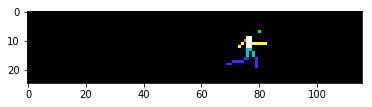

In [565]:
i = next(it)

test_set_break = int(number_of_elements*0.85)+int(number_of_elements*0.85)%2
path = WLB_TRAIN_SET_PATH

wlb_inputs = []
wlb_labels = []


update_progress(i / number_of_elements)

# Walabot data
if 'raw_image/img' in row.keys() and i+num_frames < X_wlb.shape[0]: # no walabot data for this one

    row = data.iloc[i+num_frames]

    # Generate heatmaps
    landmarks = []
    for cols in landmark_columns:
        try:
            landmarks.append([row[cols[0]]/640, row[cols[1]]/480 ])
        except TypeError:
            landmarks.append([-1, -1])

    landmarks = np.array(landmarks)

    heatmaps_wlb = generate_heatmap(25, 116, 
                        landmarks, 
                        sigma=sigma
                       )
   # clear_output()
   # plt.matshow(heatmaps_wlb[:,:,5])
   # plt.show()
   # print(landmarks)
   # time.sleep(1)

    wlb_inputs.append(X_wlb[i:i+num_frames].astype(np.uint8))
    wlb_labels.append(heatmaps_wlb.T.astype(np.float32))

plt.imshow(plotter.plot_stick_man(heatmaps_wlb))
            
        

In [571]:
Wlb_inputs.append(X_wlb[i:i+num_frames].astype(np.uint8))
Wlb_labels.append(heatmaps_wlb.T.astype(np.float32))

In [576]:
write_to_wlb_hdf(path, "wlb_{}_{}.hdf5".format(folder_name, 1+int(i/1000)), Wlb_inputs, Wlb_labels) 


In [314]:
data

,filename,keypoint_0_LAnkle_score,keypoint_0_LAnkle_x,keypoint_0_LAnkle_y,keypoint_0_LBigToe_score,keypoint_0_LBigToe_x,keypoint_0_LBigToe_y,keypoint_0_LEar_score,keypoint_0_LEar_x,keypoint_0_LEar_y,...,p2g_3_1real,raw_image/img,raw_image/phi,raw_image/power,raw_image/r,raw_image/theta,rostime,timestamp,ts3_0,ts3_1
0,2019-08-25-14-57-39_1,0.0557707,420.743,253.705,0.0677139,414.231,245.877,0.171734,484.732,228.912,...,[],NaN,NaN,NaN,NaN,NaN,1.566738e+18,NaN,[],[]
1,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.100813,479.49,225.027,...,[],NaN,NaN,NaN,NaN,NaN,1.566738e+18,NaN,[],[]
2,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.0803367,355.504,183.215,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-8.726646,1.566738e+18,1.566738e+18,[],[]
3,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.155457,483.422,227.608,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-8.726646,1.566738e+18,1.566738e+18,[],[]
4,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.151932,484.691,227.606,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-26.179939,1.566738e+18,1.566738e+18,[],[]
5,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.126121,482.116,225.026,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-26.179939,1.566738e+18,1.566738e+18,[],[]
6,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.115747,482.11,225.023,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,17.453293,1.566738e+18,1.566738e+18,[],[]
7,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.10391,480.819,226.309,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-26.179939,1.566738e+18,1.566738e+18,[],[]
8,2019-08-25-14-57-39_1,None,None,None,None,None,None,0.104378,479.51,225.028,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-26.179939,1.566738e+18,1.566738e+18,[],[]
9,2019-08-25-14-57-39_1,0.0522271,359.425,286.345,None,None,None,0.114796,480.811,226.288,...,[],"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25.0,0.0,116.0,-26.179939,1.566738e+18,1.566738e+18,[],[]


In [ ]:
X_wlb.shape

In [342]:
heatmaps_wlb

array([[[7.81090317e-27, 1.40129846e-45, 4.80267023e-41, ...,
         2.38037200e-25, 2.12022217e-34, 3.21805483e-27],
        [6.22096203e-26, 2.94272678e-44, 6.87446198e-40, ...,
         1.80813585e-24, 2.46532591e-33, 2.79042659e-26],
        [4.76038458e-25, 4.80645373e-43, 9.45419640e-39, ...,
         1.31960984e-23, 2.75420031e-32, 2.32474868e-25],
        ...,
        [6.23362703e-35, 6.98248897e-17, 2.25694178e-20, ...,
         9.00058461e-36, 6.28736578e-24, 3.81675257e-31],
        [5.40612464e-36, 1.27902926e-17, 3.51776933e-21, ...,
         7.44467768e-37, 7.96068875e-25, 3.60379532e-32],
        [4.50463377e-37, 2.25101797e-18, 5.26796112e-22, ...,
         5.91628828e-38, 9.68413351e-26, 3.26929738e-33]],

       [[1.46394604e-26, 2.80259693e-45, 7.66734468e-41, ...,
         4.19099464e-25, 2.78295854e-34, 4.50905459e-27],
        [1.16595380e-25, 4.34402524e-44, 1.09748715e-39, ...,
         3.18348881e-24, 3.23593464e-33, 3.90987321e-26],
        [8.92207403e-25, 

In [ ]:
np.shape(Wlb_inputs)

The end.